<div class="alert alert-warning">
    
<b>Disclaimer:</b> 
    
The main objective of the <i>Jupyter</i> notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function  
- setting and running the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That's one of the reasons why different minimizers have been used in the notebooks provided as examples.  
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.

</div>

# Jump sites log norm diffusion with scipy

## Introduction

<div class="alert alert-info">
    
The objective of this notebook is to show how to use one of the models of 
the <a href="https://github.com/QENSlibrary/QENSmodels">QENSlibrary</a>, <b>sqwJumpSitesLogNormDist</b>, to perform some fits. 

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html">scipy.optimize.curve_fit</a> is used for fitting.
</div>

### Physical units

For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [1]:
# Units of parameters for selected QENS model and experimental data

dict_physical_units = {'scale': "unit_of_signal.ps", 
                       'center': "1/ps", 
                       'radius': 'Angstrom', 
                       'resTime': 'ps'}

## Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import ipywidgets
import QENSmodels

## Plot fitting model

The widget below shows the peak shape function imported from QENSmodels where the function's parameters can be varied.

In [3]:
# Dictionary of initial values
ini_parameters = {'q': 1., 'scale': 5., 'center': 5., 'Nsites': 3, 'radius': 1., 'resTime':1., 'sigma': 1.}

def interactive_fct(q, scale, center, Nsites, radius, resTime, sigma):
    """
    Plot to be updated when ipywidgets sliders are modified
    """
    xs = np.linspace(-10, 10, 100)
    fig0, ax0 = plt.subplots()
    ax0.plot(xs, QENSmodels.sqwJumpSitesLogNormDist(xs, q, scale, center, Nsites, radius, resTime, sigma))
    ax0.set_xlabel('x')
    ax0.grid()

# Define sliders for modifiable parameters and their range of variations
q_slider = ipywidgets.FloatSlider(value=ini_parameters['q'],
                                  min=0.1, max=10., step=0.1,
                                  description='q', 
                                  continuous_update=False) 

scale_slider = ipywidgets.FloatSlider(value=ini_parameters['scale'],
                                      min=0.1, max=10, step=0.1,
                                      description='scale',
                                      continuous_update=False) 

center_slider = ipywidgets.IntSlider(value=ini_parameters['center'],
                                     min=-10, max=10, step=1,
                                     description='center', 
                                     continuous_update=False) 

Nsites_slider = ipywidgets.IntSlider(value=ini_parameters['Nsites'],
                                     min=2, max=10, step=1,
                                     description='Nsites',
                                     continuous_update=False)

radius_slider = ipywidgets.FloatSlider(value=ini_parameters['radius'],
                                       min=0.1, max=10, step=0.1,
                                       description='radius',
                                       continuous_update=False)

resTime_slider = ipywidgets.FloatSlider(value=ini_parameters['resTime'],
                                        min=0.1, max=10, step=0.1,
                                        description='resTime', 
                                        continuous_update=False)

sigma_slider = ipywidgets.FloatSlider(value=ini_parameters['sigma'],
                                        min=0.1, max=10, step=0.1,
                                        description='sigma', 
                                        continuous_update=False)

grid_sliders = ipywidgets.HBox([ipywidgets.VBox([q_slider, scale_slider, center_slider, Nsites_slider])
                                ,ipywidgets.VBox([radius_slider, resTime_slider, sigma_slider])])
                              
# Define function to reset all parameters' values to the initial ones
def reset_values(b):
    """
    Reset the interactive plots to inital values
    """
    q_slider.value = ini_parameters['q'] 
    scale_slider.value = ini_parameters['scale'] 
    center_slider.value = ini_parameters['center']  
    Nsites_slider.value = ini_parameters['Nsites'] 
    radius_slider.value = ini_parameters['radius'] 
    resTime_slider.value = ini_parameters['resTime']
    sigma_slider.value = ini_parameters['slider']

# Define reset button and occurring action when clicking on it
reset_button = ipywidgets.Button(description = "Reset")
reset_button.on_click(reset_values)

# Display the interactive plot
interactive_plot = ipywidgets.interactive_output(
    interactive_fct,
    {'q': q_slider, 
     'scale': scale_slider,
     'center': center_slider,
     'Nsites': Nsites_slider,
     'radius': radius_slider,
     'resTime': resTime_slider,
     'sigma': sigma_slider}
)  
                                            
display(grid_sliders, interactive_plot, reset_button)

Output()

Button(description='Reset', style=ButtonStyle())

## Creating reference data

**Input:** the reference data for this simple example correspond to sqwJumpSitesLogNormDist with added noise.

The fit is performed using `scipy.optimize.curve_fit`. <br> The example is based on implementations from https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

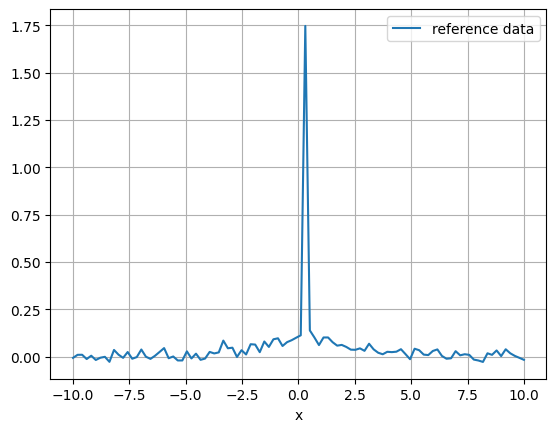

In [4]:
# Creation of reference data
nb_points = 100
xx = np.linspace(-10, 10, nb_points)
added_noise = np.random.normal(0, 1, nb_points)
sqw_jump_sites_noisy = QENSmodels.sqwJumpSitesLogNormDist(
    xx, 
    q=0.89, 
    scale=1, 
    center=0.3, 
    Nsites=5, 
    radius=2, 
    resTime=0.45, 
    sigma=0.25
) * (1. + 0.04 * added_noise) + 0.02 * added_noise

fig1, ax1 = plt.subplots()
ax1.plot(xx, sqw_jump_sites_noisy, label='reference data')
ax1.set_xlabel('x')
ax1.grid()
ax1.legend();

## Setting and fitting
From https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html  
Perform fit varying `scale`, `center`, `radius`, `resTime` and `sigma`. 
`Nsites` and `q` are fixed to 5 and 0.89, respectively.

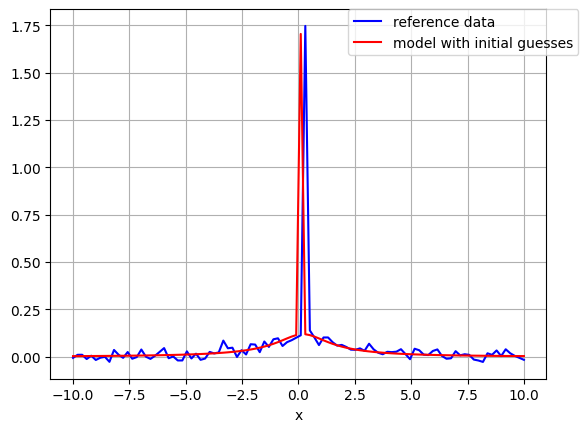

In [5]:
def func_to_fit(xx, scale, center, radius, resTime, sigma):
    return QENSmodels.sqwJumpSitesLogNormDist(
        xx, 
        0.89, 
        scale, 
        center, 
        5, 
        radius, 
        resTime, 
        sigma)

fig2, ax2 = plt.subplots()
ax2.plot(xx, sqw_jump_sites_noisy, 'b-', label='reference data')
ax2.plot(xx, 
         QENSmodels.sqwJumpSitesLogNormDist(
             xx, 
             0.89, 
             scale=0.95, 
             center=0.2, 
             Nsites=5, 
             radius=2, 
             resTime=0.45, 
             sigma=0.25
         ), 
         'r-', 
         label='model with initial guesses')
ax2.set_xlabel('x')
ax2.grid()
ax2.legend(bbox_to_anchor=(0.6, 1), loc=2, borderaxespad=0.);

In [6]:
success_fit = True

try:
    popt, pcov = curve_fit(
        func_to_fit, 
        xx, 
        sqw_jump_sites_noisy, 
        p0=[0.95, 0.2, 2, 0.45, 0.25], 
        bounds=((0.1, -2, 0.1, 0.1, 0.1), 
                (5., 2., 5., 11., 1.))
    )
    
except RuntimeError:
    success_fit = False
    print("Error - curve_fit failed")

## Plotting the results

Calculation of the errors on the refined parameters

In [7]:
if success_fit: 
    perr = np.sqrt(np.diag(pcov))
    print(
        "Values of refined parameters:\n"
        f"scale: {popt[0]} +/- {perr[0]} {dict_physical_units['scale']}\n"
        f"center {popt[1]} +/- {perr[1]} {dict_physical_units['center']}\n"
        f"radius: {popt[2]} +/- {perr[2]} {dict_physical_units['radius']}\n"
        f"resTime: {popt[3]} +/- {perr[3]} {dict_physical_units['resTime']}\n"
        f"sigma: {popt[4]} +/- {perr[4]}"
    )

Values of refined parameters:
scale: 1.9096072979837913 +/- 0.2648608568483786 unit_of_signal.ps
center 0.342073883505371 +/- 0.2573380929761853 1/ps
radius: 4.999999999999999 +/- 33.59669925356897 Angstrom
resTime: 0.14626722132107697 +/- 0.7559034928398951 ps
sigma: 0.9999999999999999 +/- 0.26792555744643887


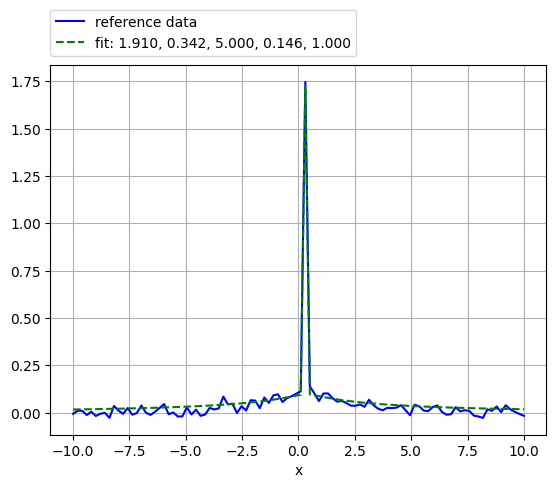

In [8]:
# Comparison of reference data with fitting result
if success_fit: 
    fig3, ax3 = plt.subplots()
    ax3.plot(xx, sqw_jump_sites_noisy, 'b-', label='reference data')
    ax3.plot(xx, func_to_fit(xx, *popt), 'g--', label='fit: %5.3f, %5.3f, %5.3f, %5.3f, %5.3f' % tuple(popt))
    ax3.legend(bbox_to_anchor=(0., 1.15), loc='upper left', borderaxespad=0.)
    ax3.set_xlabel('x')
    ax3.grid();